## Загрузка данных

In [1]:
!pip install gdown

### Загрузка картинок

In [2]:
!gdown https://drive.google.com/uc?id=1Usn-XgKql3aUAQcbt5S4-BEM7Zg8Jgwq
!unzip -qq AllRecipes_images.zip
!rm AllRecipes_images.zip

Downloading...
From: https://drive.google.com/uc?id=1Usn-XgKql3aUAQcbt5S4-BEM7Zg8Jgwq
To: /content/AllRecipes_images.zip
4.02GB [01:06, 60.9MB/s]


In [ ]:
import os
print(f"Train amount - {len(os.listdir('AllRecipes_images/train'))}")
print(f"Val amount - {len(os.listdir('AllRecipes_images/val'))}")

Train amount - 162547
Val amount - 40648


### Загрузка ингредиентов блюд

In [3]:
!gdown https://drive.google.com/uc?id=1vc2OT7zAGlcbMi25Or2JUWLevES238aS
!gdown https://drive.google.com/uc?id=11gUIVJrOmdc0edYF9eHT11DrhYFnuxM2
!gdown https://drive.google.com/uc?id=1Oj-tq8L0mU34kjIo7DWjG9uxeXZPMrkP

Downloading...
From: https://drive.google.com/uc?id=1vc2OT7zAGlcbMi25Or2JUWLevES238aS
To: /content/recipes_raw.json
12.0MB [00:00, 56.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=11gUIVJrOmdc0edYF9eHT11DrhYFnuxM2
To: /content/clean_ingred.txt
100% 1.44k/1.44k [00:00<00:00, 2.07MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oj-tq8L0mU34kjIo7DWjG9uxeXZPMrkP
To: /content/rus_clean_ingred.txt
100% 2.88k/2.88k [00:00<00:00, 5.15MB/s]


## Проверка данных

Проверка на битые картинки

In [ ]:
def check_bad_img(path_to_img, img_size):
  bad_imgs_count = 0
  for file_name in tqdm(os.listdir(path_to_img), desc='Checking images'):
    img = Image.open(path_to_img + file_name).convert('RGB')
    if img.size != img_size:
      print(f'Image {file_name} size - {img.size}')
      bad_imgs_count += 1
  print(f'Total bad images found = {bad_imgs_count}')

path_to_img = 'AllRecipes_images/'
check_bad_img(path_to_img, (250, 250))


Total bad images found = 0


## Exploratory data analysis

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
import json
import os

In [ ]:
recipe_list = []
with open('recipes_raw.json', 'r') as f:
  recipe_list = json.load(f)

In [ ]:
len_ingred_count = Counter()

for recipe in recipe_list:
  len_ingred_count[len(recipe['ingred_list'])] += 1

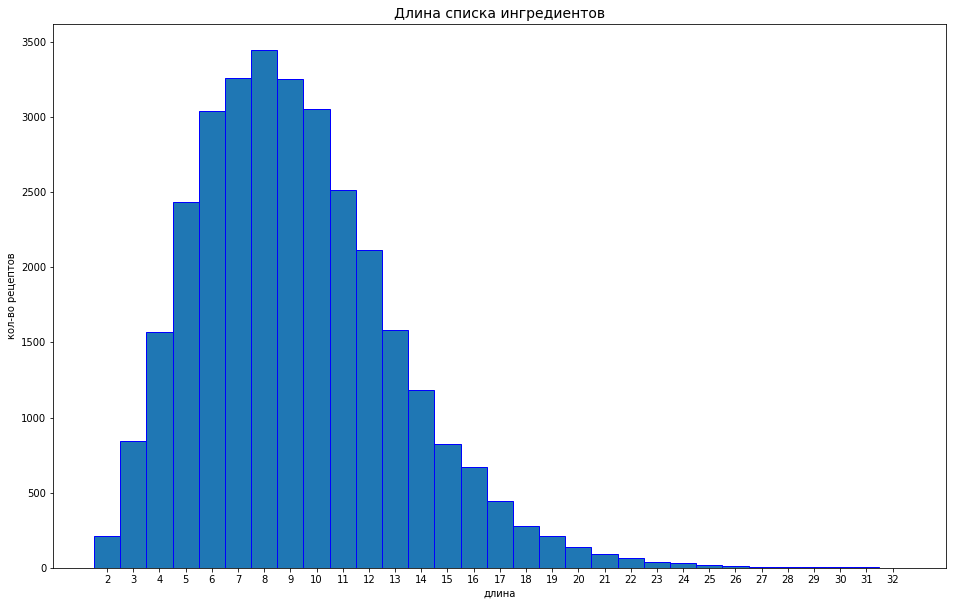

In [ ]:
labels, values = zip(*len_ingred_count.items())
indexes = np.arange(min(labels), max(labels) + 1)

plt.figure(figsize=(16, 10))
plt.title('Длина списка ингредиентов', fontsize=14)
width = 1
plt.bar(labels, values, width, edgecolor='b')
plt.xticks(indexes)
plt.xlabel('длина')
plt.ylabel('кол-во рецептов')
plt.show()

In [ ]:
imgs_list = set(os.listdir('AllRecipes_images'))

img_on_recipe = defaultdict(list)

for recipe in tqdm(recipe_list):
  recipe_id = recipe['id']
  i = 0
  while True:
    img = f'{recipe_id}_{i}.jpg'
    if img in imgs_list:
      i += 1
    else:
      img_on_recipe[i].append(recipe_id)
      break

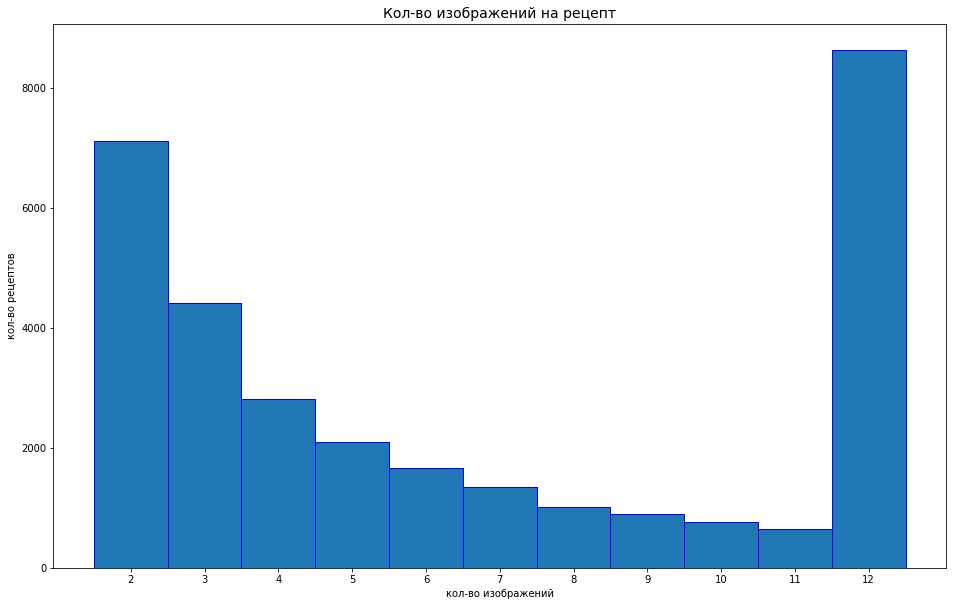

In [ ]:
labels = list(img_on_recipe.keys())
values = [len(l) for l in img_on_recipe.values()]
indexes = np.arange(min(labels), max(labels) + 1)

plt.figure(figsize=(16, 10))
plt.title('Кол-во изображений на рецепт', fontsize=14)
width = 1
plt.bar(labels, values, width, edgecolor='b')
plt.xticks(indexes)
plt.xlabel('кол-во изображений')
plt.ylabel('кол-во рецептов')
plt.show()

## Preprocessing

In [4]:
from PIL import Image
from tqdm.notebook import tqdm
import os
import json

Препроцессинг ингредиентов

In [5]:
with open('recipes_raw.json', 'rb') as f:
  recipe_list = json.loads(f.read())

In [6]:
import html
from html.parser import HTMLParser
import re
import unicodedata

REPLACEMENTS = {
    u'\x91':"'", u'\x92':"'", u'\x93':'"', u'\x94':'"', u'\xa9':'',
    u'\xba': ' degrees ', u'\xbc':' 1/4', u'\xbd':' 1/2', u'\xbe':' 3/4',
    u'\xd7':'x', u'\xae': '',
    '\\u00bd':' 1/2', '\\u00bc':' 1/4', '\\u00be':' 3/4',
    u'\\u2153':' 1/3', '\\u00bd':' 1/2', '\\u00bc':' 1/4', '\\u00be':' 3/4',
    '\\u2154':' 2/3', '\\u215b':' 1/8', '\\u215c':' 3/8', '\\u215d':' 5/8',
    '\\u215e':' 7/8', '\\u2155':' 1/5', '\\u2156':' 2/5', '\\u2157':' 3/5',
    '\\u2158':' 4/5', '\\u2159':' 1/6', '\\u215a':' 5/6', '\\u2014':'-',
    '\\u0131':'1', '\\u2122':'', '\\u2019':"'", '\\u2013':'-', '\\u2044':'/',
    '\\u201c':'\\"', '\\u2018':"'", '\\u201d':'\\"', '\\u2033': '\\"',
    '\\u2026': '...', '\\u2022': '', '\\u2028': ' ', '\\u02da': ' degrees ',
    '\\uf04a': '', u'\xb0': ' degrees ', '\\u0301': '', '\\u2070': ' degrees ',
    '\\u0302': '', '\\uf0b0': ''
}

parser = HTMLParser()
def prepro_txt(text):
    import urllib

    text = html.unescape(text)

    for unichar, replacement in REPLACEMENTS.items():
      if unichar in text:
        text = text.replace(unichar, replacement)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')

    try:
        text = urllib.parse.unquote(text.decode('ascii'))
    except UnicodeDecodeError:
        pass # if there's an errant %, unquoting will yield an invalid char

    # some extra tokenization
    text = ' - '.join(text.split('-'))
    text = ' & '.join(text.split('&'))

    text = re.sub(r'\\[nt]', ' ', text) # remove over-escaped line breaks and tabs
    text = re.sub(r'\b([^\d\s]+)/(.*)\b', r'\1 / \2', text) # split non-fractions
    text = re.sub(r'\b(.*)/([^\d\s]+)\b', r'\1 / \2', text) # e.g. 350 deg/gas mark
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace

    return text.strip()

In [7]:
for recipe in tqdm(recipe_list, desc='Preprocess ingredients'):
  ingred_list = recipe['ingred_list']
  new_ingred_list = []
  for ingred in ingred_list:
    new_ingred_list.append(prepro_txt(ingred))
  recipe['ingred_list'] = new_ingred_list

In [8]:
from string import ascii_lowercase
def replace_units(s):
  tokens = s.replace('to taste', '').split()
  units = ['ounce', 'ounces', 'cups', 'cup', 'teaspoon', 'tablespoon', 'tablespoons', 'teaspoons', 
           'c', 'g', 'v', 'tbsp', 'x', 'ml', 'lb', 'tbs', 'oz', 'pkg', 'large', 'small', 'tsp', 'inch', 
           'grams', 'quarts', 'lbs', 'can', 'cube', 'whole', 'or', 'pieces', 'piece', 'chopped', 
           'shredded', 'diced', 'fresh', 'crushed', 'minced']
  tokens_new = []
  for t in tokens:
      if t not in units:
          tokens_new.append(t)
  
  return ' '.join(tokens_new)

def cleanup_ingredient_list(l):
    l = [replace_units(''.join([char for char in x.lower() if char in ascii_lowercase + ' ']).strip()) for x in l]
    return l

In [9]:
for recipe in tqdm(recipe_list, desc='Preprocess ingredients'):
  recipe['ingred_list'] = cleanup_ingredient_list(recipe['ingred_list'])

In [10]:
import csv
import re
from collections import Counter
from itertools import permutations as permut

clean_ingredients - эталонный список ингредиентов

In [ ]:
# clean_ingredients = set()

# with open('nndb_flat.csv', 'r') as f:
#   reader = csv.reader(f)
#   next(reader)
#   for row in tqdm(reader):
#     row = row[3].lower()
#     row = re.sub(r'\([^)]*\)', '', row)
#     row = re.split(r',\s', row)
#     row = [item.strip() for item in row]
#     trigrams = []
#     for bigram in permut(row[:0:-1], 2):
#       trigram = re.sub(r',', '', ' '.join([*bigram, row[0]])).strip()
#       trigrams.append(trigram)
#     bigrams = []
#     for unigram in row[:0:-1]:
#       bigram = re.sub(r',', '', ' '.join([unigram, row[0]])).strip()
#       bigrams.append(bigram)
#     candidates = [*trigrams, *bigrams, row[0]]

#     clean_ingredients.update(candidates)

# clean_ingredients = list(clean_ingredients)

In [11]:
with open('clean_ingred.txt', 'r') as f:
  clean_ingredients = set(f.read().split('\n'))
print(len(clean_ingredients))

187


In [12]:
import inflect
engine = inflect.engine()


def get_another_form(word):
  def is_singular(word):
    return engine.singular_noun(word) == False
  if is_singular(word):
    return engine.plural_noun(word)
  else:
    return engine.singular_noun(word)


SYNONIMS_DICT = {'whipping cream' : 'whipped cream',
                 'rolled oats' : 'cereals',
                 'berry jell' : 'jell',
                 'strawberry jell' : 'jell',
                 'lime jell' : 'jell',
                 'vanilla jell' : 'jell',
                 'cherry jell' : 'jell',
                 'raspberry jell' : 'jell',
                 'orange jell' : 'jell',
                 'watemelon jell' : 'jell',
                 'lima beans' : 'beans',
                 'kidney beans' : 'beans',
                 'pinto beans' : 'beans',
                 'serrano pepper' : 'chili pepper',
                 'light cream' : 'cream cheese',
                 'cheese spread' : 'cream cheese',
                 'caraway seeds' : 'cumin seeds',
                 'marmalade' : 'jam',
                 'jellybeans' : 'candy',
                 'hot dog' : 'sausage',
                 'pepperoni' : 'sausage',
                 'pastry' : 'dough',
                 'vermout' : 'alcohol',
                 'vodka' : 'alcohol',
                 'liqueur' : 'alcohol',
                 'liquor' : 'alcohol',
                 'vermouth' : 'alcohol',
                 'whiskey' : 'alcohol',
                 'mozzarella' : 'soft cheese',
                 'parmesan' : 'hard cheese',
                 'cheddar' : 'hard cheese',
                 'dip' : 'sauce'
                 }


def clean_ingredient_list(ingr_list, clean_ingredients):
    recipe = []
    for ingr in ingr_list:
      ingr = ingr.split()
      ingr_found = False
      for trigram in permut(ingr, 3):
        trigram = ' '.join(trigram)
        another_form = get_another_form(trigram)
        if trigram in SYNONIMS_DICT:
          trigram = SYNONIMS_DICT[trigram]
        if another_form in SYNONIMS_DICT:
          trigram = SYNONIMS_DICT[another_form]
        if trigram in clean_ingredients:
          recipe.append(trigram)
          ingr_found = True
          break
        if another_form in clean_ingredients:
          recipe.append(another_form)
          ingr_found = True
          break
      if ingr_found:
        continue
      for bigram in permut(ingr, 2):
        bigram = ' '.join(bigram)
        another_form = get_another_form(bigram)
        if bigram in SYNONIMS_DICT:
          bigram = SYNONIMS_DICT[bigram]
        if another_form in SYNONIMS_DICT:
          bigram = SYNONIMS_DICT[another_form]
        if bigram in clean_ingredients:
          recipe.append(bigram)
          ingr_found = True
          break
        if another_form in clean_ingredients:
          recipe.append(another_form)
          ingr_found = True
          break
      if ingr_found:
        continue
      for unigram in ingr[::-1]:
        if unigram in SYNONIMS_DICT:
          unigram = SYNONIMS_DICT[unigram]
        another_form = get_another_form(unigram)
        if another_form in SYNONIMS_DICT:
          unigram = SYNONIMS_DICT[another_form]
        if unigram in clean_ingredients:
          recipe.append(unigram)
          break
        if another_form in clean_ingredients:
          recipe.append(another_form)
          break

    return list(set(recipe))

In [13]:
for recipe in tqdm(recipe_list):
  recipe['ingred_list'] = clean_ingredient_list(recipe['ingred_list'], clean_ingredients)

In [14]:
empty_recipes = []
for recipe in recipe_list:
  if len(recipe['ingred_list']) == 0:
    print(recipe)
    empty_recipes.append(recipe['id'])
print(f'Рецептов с пустым списком ингред-ов - {len(empty_recipes)}')

{'id': '24035', 'item_name': 'Kalua Pig in a Slow Cooker', 'ingred_list': []}
{'id': '32649', 'item_name': 'Margaritas', 'ingred_list': []}
{'id': '16901', 'item_name': "Ronaldo's Beef Carnitas", 'ingred_list': []}
{'id': '17143', 'item_name': 'Kosher Salt Encrusted Prime Rib Roast', 'ingred_list': []}
{'id': '42264', 'item_name': 'Homemade Butter', 'ingred_list': []}
{'id': '16574', 'item_name': 'Slow Cooker Lancaster County Pork and Sauerkraut', 'ingred_list': []}
{'id': '37952', 'item_name': 'Deep-Fried Turkey Marinade', 'ingred_list': []}
{'id': '20964', 'item_name': 'Oven Kalua Pork', 'ingred_list': []}
{'id': '19478', 'item_name': 'Easiest Spicy Cod', 'ingred_list': []}
{'id': '20559', 'item_name': 'Tri-Tip Rub', 'ingred_list': []}
{'id': '14710', 'item_name': 'Bohemian Pork Roast', 'ingred_list': []}
{'id': '231085', 'item_name': 'Greek Pulled Pork', 'ingred_list': []}
{'id': '106695', 'item_name': 'Prosciutto e Melone (Italian Ham and Melon)', 'ingred_list': []}
{'id': '269652'

Удалим их

In [15]:
recipe_list = [recipe for recipe in recipe_list if len(recipe['ingred_list']) > 0]

with open('recipes.json', 'w') as f:
  f.write(json.dumps(recipe_list, indent=2))

In [16]:
for img in os.listdir('AllRecipes_images/train'):
  img_name = img.split('_')[0]
  if img_name in empty_recipes:
    os.remove(os.path.join('AllRecipes_images/train', img))

for img in os.listdir('AllRecipes_images/val'):
  img_name = img.split('_')[0]
  if img_name in empty_recipes:
    os.remove(os.path.join('AllRecipes_images/val', img))

In [17]:
import os
print(f"Train amount - {len(os.listdir('AllRecipes_images/train'))}")
print(f"Val amount - {len(os.listdir('AllRecipes_images/val'))}")

Train amount - 162437
Val amount - 40615


Посмотрим, сколько уникальных инг-ов в датасете

In [19]:
all_ingred = []

for recipe in tqdm(recipe_list):
    all_ingred.extend(recipe['ingred_list'])

print(f'Found {len(set(all_ingred))} unique ingredients in dataset of all recipes') 


Found 185 unique ingredients in dataset of all recipes


In [20]:
from collections import Counter
c = Counter(all_ingred)
print('Most popular ingredients:')
c.most_common(20)

Most popular ingredients:


[('sugar', 11403),
 ('onion', 10791),
 ('oil', 10531),
 ('butter', 9565),
 ('egg', 8906),
 ('flour', 8361),
 ('cheese', 6784),
 ('water', 6725),
 ('milk', 5804),
 ('chicken', 5076),
 ('vanilla', 4521),
 ('juice', 4184),
 ('sauce', 4035),
 ('tomato', 3711),
 ('cinnamon', 3060),
 ('baking powder', 2723),
 ('beef', 2516),
 ('red pepper', 2500),
 ('baking soda', 2476),
 ('potato', 2460)]

## Обучение

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [32]:
with open('recipes.json', 'rb') as f:
  recipe_list = json.loads(f.read())
with open('clean_ingred.txt', 'r') as f:
  clean_ingredients = set(f.read().split('\n'))

In [ ]:
en2ru = {}
with open('clean_ingred.txt', 'r') as f:
  en=f.readlines()
with open('rus_clean_ingred.txt', 'r') as f:
  ru=f.readlines()

for e, r in zip(en, ru):
  en2ru[e.rstrip('\n')] = r.rstrip('\n')
with open('en2ru_ing.json', 'w') as f:
  json.dump(en2ru, f)

In [33]:
id2word = defaultdict()
id2word[0] = '<start>'
id2word[1] = '<end>'
id2word[2] = '<pad>'
for i, ingr in enumerate(clean_ingredients):
  id2word[i+3] = ingr

word2id = {v:k for k,v in id2word.items()}

In [34]:
def ids2words(word_ids):
  result = []
  for id in word_ids:
    word = id2word[id]
    if word == '<start>':
      continue
    elif word == '<end>':
      break
    else:
      result.append(word)
  return result

def words2ids(words):
  return [word2id[word] for word in words]

In [35]:
class RecipesDataset(Dataset):
  def __init__(self, recipes_json, img_folder, transform=None):
    super().__init__()

    with open(recipes_json, 'r') as f:
      recipes = json.load(f)
    self.recipes = defaultdict(dict)
    for recipe in recipes:
      recipe['ingred_list'].insert(0, '<start>')
      recipe['ingred_list'].append('<end>')
      self.recipes[recipe['id']] = recipe

    self.img_folder = img_folder
    self.imgs = os.listdir(self.img_folder)
    self.imgs = [img for img in self.imgs if img.split('_')[0] in self.recipes]
    
    self.transform = transform

  def __getitem__(self, index):
    img_name = self.imgs[index]
    img = Image.open(self.img_folder + img_name).convert('RGB')
    if self.transform is not None:
      img = self.transform(img)
    
    recipe_id = img_name.split('_')[0]
    ingred_list = self.recipes[recipe_id]['ingred_list']
    return img, torch.LongTensor(words2ids(ingred_list))

  def __len__(self):
    return len(self.imgs)

In [36]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(data):
  # отсортируем по длине описания
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)
  
  # составим 4D тензор изображений из кортежа 3D тензоров
  # images: (batch_size, channels(rgb), width, height)
  images = torch.stack(images, 0)

  # составим 2D тензор описаний из кортежа 1D тензоров
  # дополним каждое описание символом <pad> так, чтобы у всех описаний совпадали длины
  lengths = [len(cap) for cap in captions]
  targets = torch.LongTensor(np.zeros((len(captions), max(lengths))))
  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]  

  return images, targets, lengths

In [37]:
class Encoder(nn.Module):
  def __init__(self, encoder, encod_size, embed_size, finetune=False):
    super().__init__()
    
    self.finetune = False

    modules = list(encoder.children())[:-1]
    self.resnet = nn.Sequential(*modules)

    # self.linear = nn.Sequential(nn.Conv2d(encoder.fc.in_features, embed_size, kernel_size=1, padding=0),
    #                                 nn.Dropout2d(dropout))
    self.linear = nn.Linear(encod_size, embed_size)
  
  def finetune_active(self, activate, num_layers):
    for layer in list(self.resnet.children()):
      for param in layer.parameters():
        param.requires_grad = False
    if activate:
      self.finetune = True
      for layer in list(self.resnet.children())[-num_layers:]:
        for param in layer.parameters():
          param.requires_grad = True
    else:
      self.finetune = False
      for layer in list(self.resnet.children())[-num_layers:]:
        for param in layer.parameters():
          param.requires_grad = False
  
  def forward(self, images):
    if not self.finetune:  
      with torch.no_grad():
        features = self.resnet(images)
    else:
        features = self.resnet(images)
    features = features.view(features.size(0), -1)
    features = self.linear(features)
    return features

In [38]:
class Decoder(nn.Module):
    def __init__(self, encod_size, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, embed_size)
      self.rnn = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True,
                         dropout=dropout)
      self.linear = nn.Linear(hidden_size, vocab_size)
  
    # обучение, используются истинные описания
    def forward(self, features, captions, lengths):
      embed = self.embedding(captions)
      embed = torch.cat((features.unsqueeze(1), embed), 1)
      packed = pack_padded_sequence(embed, lengths, batch_first=True)
      outputs, _ = self.rnn(packed)
      outputs = self.linear(outputs[0])
      return outputs

    # проверка, истинные описания не используются
    def sample(self, features, max_len, states=None):
      id_preds = list()
      inputs = features.unsqueeze(1)
      for i in range(max_len):
        rnn_outputs, states = self.rnn(inputs, states)
        lin_outputs = self.linear(rnn_outputs.squeeze(1))
        _, pred_id = lin_outputs.max(1)
        id_preds.append(pred_id)
        inputs = self.embedding(pred_id).unsqueeze(1)
      id_preds = torch.stack(id_preds, 1)
      return id_preds

In [ ]:
!pip install googletrans

In [39]:
def label2onehot(labels, pad_value=len(word2id)-1):
    # input labels to one hot vector
    inp_ = torch.unsqueeze(labels, 2)
    one_hot = torch.FloatTensor(labels.size(0), labels.size(1), pad_value + 1).zero_().to(device)
    one_hot.scatter_(2, inp_, 1)
    one_hot, _ = one_hot.max(dim=1)
    # remove pad and eos position
    one_hot = one_hot[:, 1:-1]
    one_hot[:, 0] = 0

    return one_hot

def compute_metrics(ret_metrics, error_types, metric_names, eps=1e-10, weights=None):
    if 'accuracy' in metric_names:
        ret_metrics['accuracy'].append(np.mean((error_types['tp_i'] + error_types['tn_i']) / (error_types['tp_i'] + error_types['fp_i'] + error_types['fn_i'] + error_types['tn_i'])))
    if 'jaccard' in metric_names:
        ret_metrics['jaccard'].append(error_types['tp_all'] / (error_types['tp_all'] + error_types['fp_all'] + error_types['fn_all'] + eps))
    if 'dice' in metric_names:
        ret_metrics['dice'].append(2*error_types['tp_all'] / (2*(error_types['tp_all'] + error_types['fp_all'] + error_types['fn_all']) + eps))
    if 'f1' in metric_names:
        pre = error_types['tp_i'] / (error_types['tp_i'] + error_types['fp_i'] + eps)
        rec = error_types['tp_i'] / (error_types['tp_i'] + error_types['fn_i'] + eps)
        f1_perclass = 2*(pre * rec) / (pre + rec + eps)
        if 'f1_ingredients' not in ret_metrics.keys():
            ret_metrics['f1_ingredients'] = [np.average(f1_perclass, weights=weights)]
        else:
            ret_metrics['f1_ingredients'].append(np.average(f1_perclass, weights=weights))

        pre = error_types['tp_all'] / (error_types['tp_all'] + error_types['fp_all'] + eps)
        rec = error_types['tp_all'] / (error_types['tp_all'] + error_types['fn_all'] + eps)
        f1 = 2*(pre * rec) / (pre + rec + eps)
        ret_metrics['f1'].append(f1)

In [40]:
from random import randint
from googletrans import Translator
translator = Translator()

val_images = os.listdir('AllRecipes_images/val')

def predict_val_image():
  with torch.no_grad():
    img_name = val_images[randint(0, len(val_images)-1)]
    recipe_id = img_name.split('_')[0]
    img = Image.open(os.path.join('AllRecipes_images/val', img_name))
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = transform_val(img).to(device).unsqueeze(0)
    #print(label2onehot(decoder.sample(encoder(img), 20)))
    ingred_pred = ids2words(decoder.sample(encoder(img), 20)[0].cpu().numpy())
    ingred_pred = [ing for ing in ingred_pred]
    ingred_pred = [en2ru[ing] for ing in ingred_pred]
    
    dish_name = train_data.recipes[recipe_id]['item_name']
    dish_name = translator.translate(dish_name, src='en', dest='ru').text
    ingred_real = train_data.recipes[recipe_id]['ingred_list']
    ingred_real = [ing for ing in ingred_real[1:-1]]
    ingred_real = [en2ru[ing] for ing in ingred_real[1:-1]]
    print(dish_name + ':', end='\n\n')
    print('Real:')
    print('\t' + '\n\t'.join(ingred_real), end='\n\n')
    print('Prediction:')
    print('\t' + '\n\t'.join(ingred_pred))

In [12]:
def predict_image(path_to_img, transform):
  with torch.no_grad():
    img = Image.open(path_to_img).convert('RGB')
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = transform(img).to(device).unsqueeze(0)
    ingred_pred = ids2words(decoder.sample(encoder(img), 20)[0].cpu().numpy())
    ingred_pred = [en2ru[ing] for ing in ingred_pred]
    print('\t' + '\n\t'.join(ingred_pred))

In [41]:
def update_error_types(error_types, y_pred, y_true):
  error_types['tp_i'] += (y_pred * y_true).sum(0).cpu().data.numpy()
  error_types['fp_i'] += (y_pred * (1-y_true)).sum(0).cpu().data.numpy()
  error_types['fn_i'] += ((1-y_pred) * y_true).sum(0).cpu().data.numpy()
  error_types['tn_i'] += ((1-y_pred) * (1-y_true)).sum(0).cpu().data.numpy()

  error_types['tp_all'] += (y_pred * y_true).sum().item()
  error_types['fp_all'] += (y_pred * (1-y_true)).sum().item()
  error_types['fn_all'] += ((1-y_pred) * y_true).sum().item()

In [59]:
def train(encoder, decoder, criterion, optimizer, num_epochs,
          epoch_losses, start_epoch, save_path):

  for epoch in range(start_epoch, num_epochs + start_epoch):
    # режим обучения
    encoder.train()
    decoder.train()

    running_loss = 0.0
    print(f'Эпоха {epoch}/{start_epoch + num_epochs - 1}')
    for images, tokens, lengths in tqdm(train_loader, desc=f'Обучение {epoch}'):
      # Перенесем изобр-я и описания на GPU, составим вектор истинных описаний
      images = images.to(device)
      tokens = tokens.to(device)
      targets = pack_padded_sequence(tokens, lengths, batch_first=True)[0]

      # Проведем изобр-я через модель, получим описания (в виде векторов id), сгенерир. моделью
      features = encoder(images)
      outputs = decoder(features, tokens[:, :-1], lengths)
      
      # посчитать лосс на батче
      loss = criterion(outputs, targets)
      
      # посчитать градиенты
      loss.backward()
      
      # обновить параметры модели
      optimizer.step()
      
      # обнулить градиенты
      optimizer.zero_grad()

      running_loss += loss.item()

    if encoder.finetune:
      torch.save(encoder.state_dict(), f'{save_path}/enc_{epoch}_epoch.pth')

    torch.save(decoder.state_dict(), f'{save_path}/dec_{epoch}_epoch.pth')
    
    train_loss = running_loss / len(train_loader)
    epoch_losses['train_nll'].append(train_loss)

    # Validation
    encoder.eval()
    decoder.eval()
    error_types = {'tp_i': 0, 'fp_i': 0, 'fn_i': 0, 'tn_i': 0, 'tp_all': 0, 'fp_all': 0, 'fn_all': 0}
    for images, tokens, lengths in tqdm(val_loader, desc=f'Валидация'):
      images = images.to(device)
      tokens = tokens.to(device)
      tokens_oh = label2onehot(tokens)

      with torch.no_grad():
        pred = decoder.sample(encoder(images), 20)
      pred_oh = label2onehot(pred)
      update_error_types(error_types, pred_oh, tokens_oh)

      val_metrics = {'accuracy': [], 'f1': [], 'jaccard': [], 'f1_ingredients': []}
      compute_metrics(val_metrics, error_types, ['accuracy', 'f1', 'jaccard', 'f1_ingredients'],
                      eps=1e-10,
                      weights=None)

    print(f'Train loss:\t{train_loss:.4f}')
    print(f'Val metrics:\n\t', end='')
    for k, v in val_metrics.items():
      print(f'{k}: {np.mean(v):.4f}', end=' ')
      epoch_losses[k].append(v)
    print()

In [53]:
transform_train = transforms.Compose([
  transforms.RandomResizedCrop((224, 224)),
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_data = RecipesDataset('recipes.json', 'AllRecipes_images/train/', transform_train)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=True)

In [54]:
transform_val = transforms.Compose([
  transforms.Resize((250, 250)),
  transforms.CenterCrop((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_data = RecipesDataset('recipes.json', 'AllRecipes_images/val/', transform_val)

batch_size = 128
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=False)

In [67]:
embed_size = 300
rnn_hidden_size = 512
encod_size = 2048
encoder = Encoder(models.resnet50(pretrained=True), encod_size, embed_size, 
                  finetune=False).to(device)
num_finetune = 3
encoder.finetune_active(True, num_finetune)

decoder = Decoder(encod_size, embed_size, rnn_hidden_size, len(word2id), dropout=0.5).to(device)
for p in decoder.rnn.parameters():
  p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

finetune_params = []
for layer in list(encoder.resnet.children())[-num_finetune:]:
  finetune_params.extend(layer.parameters())


criterion = nn.CrossEntropyLoss()
torch.manual_seed(42)
optimizer = optim.Adadelta(params=list(decoder.parameters()) + finetune_params + list(encoder.linear.parameters()))

In [ ]:
epoch_losses = defaultdict(list)

train(encoder, decoder, criterion, optimizer, num_epochs=10, epoch_losses=epoch_losses, 
      start_epoch=1, save_path='/content/drive/My Drive/Dish-id/weights_3')

Эпоха 1/10


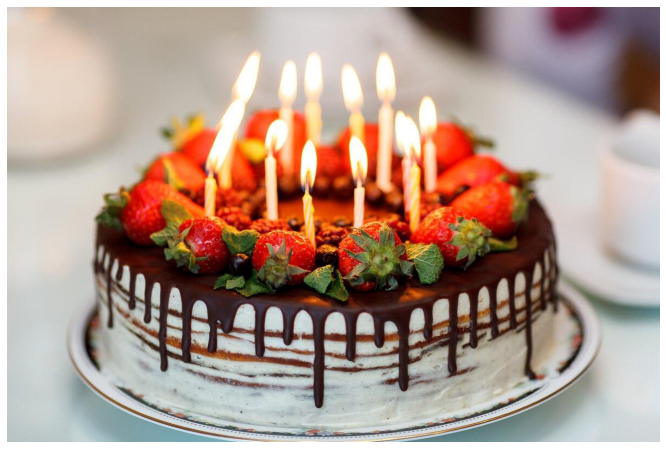

	шоколад
	сливочное масло
	ваниль
	сахар
	яйцо
	какао


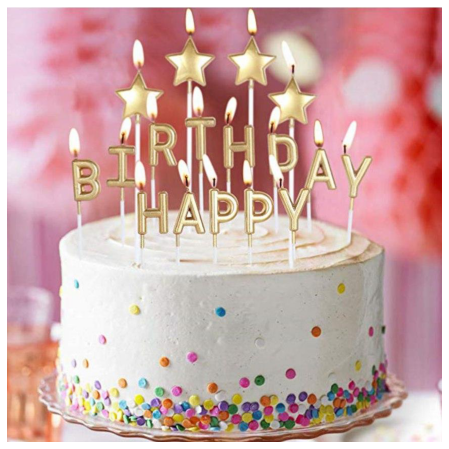

	мука
	сливочное масло
	молоко
	сахар
	ваниль
	разрыхлитель
	соль
	яйцо


In [ ]:
encoder.load_state_dict(torch.load(f'/content/drive/My Drive/Dish-id/weights/enc_100_epoch.pth'))
encoder.finetune = False
decoder.load_state_dict(torch.load(f'/content/drive/My Drive/Dish-id/weights/dec_100_epoch.pth'))
encoder.eval()
decoder.eval()
predict_image('/content/photo_2020-07-10_09-08-01.jpg', transform_val)
predict_image('/content/photo_2020-07-10_21-33-13.jpg', transform_val)

In [ ]:
np.arange(60, 111, 10)

array([ 60,  70,  80,  90, 100, 110])

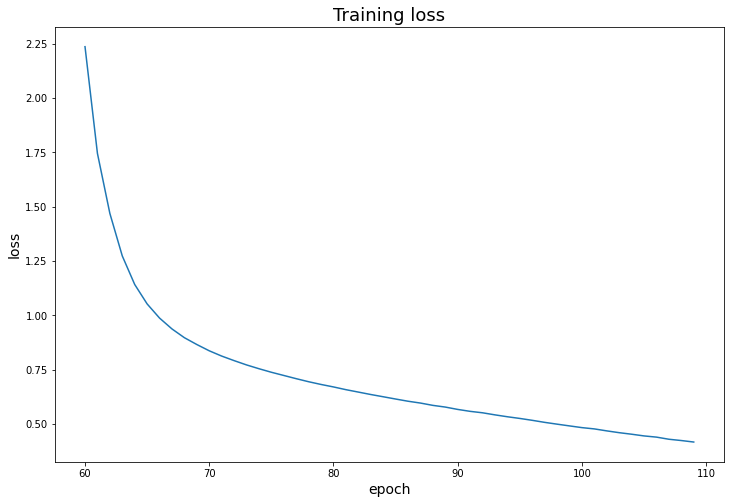

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(epoch_losses['train_nll'])
plt.xticks(ticks=np.arange(0, 51, 10), labels=np.arange(60, 111, 10))
plt.title('Training loss', fontsize=18)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.show()

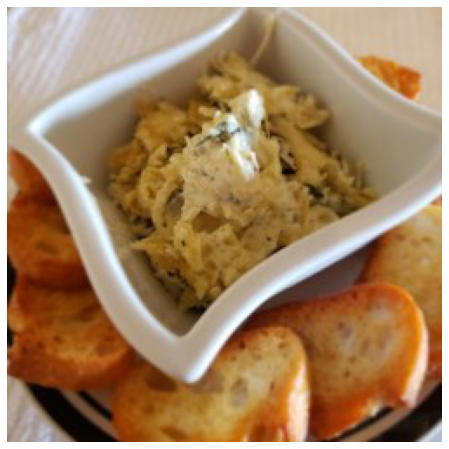

Горячий артишок и соус из шпината II:

Real:
	гвоздика
	сыр
	майонез
	пармезан
	уксус
	сливочный сыр
	соль
	чеснок
	моцарелла

Prediction:
	лимон
	сливочное масло
	майонез
	лук
	крабовое мясо
	спаржа


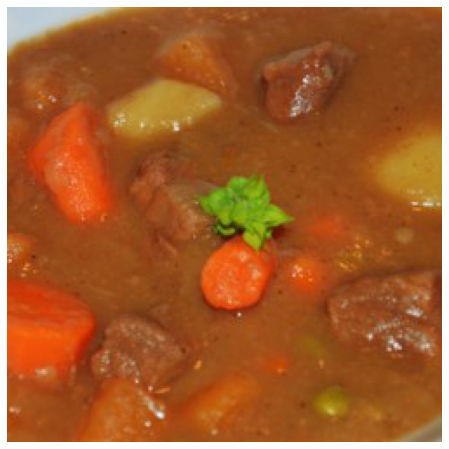

Грамм ирландское рагу:

Real:
	вода
	говядина
	овощи
	соус
	морковь
	картофель
	лук
	грибы
	соль

Prediction:
	помидор
	говядина
	овощи
	тимьян
	морковь
	гороха
	картофель
	лук
	красный перец
	грибы


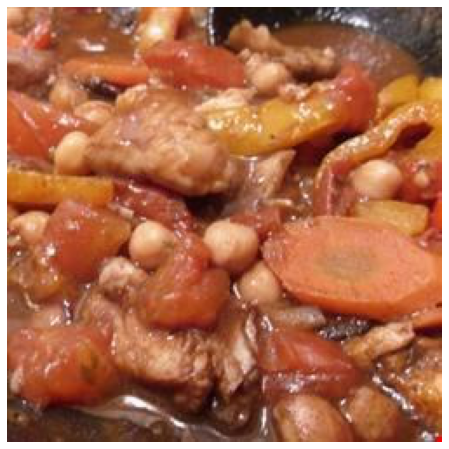

Испанская марокканская рыба:

Real:
	перец
	гвоздика
	овощи
	молотый тмин
	морковь
	паприка
	красный перец
	лук
	оливки
	соль
	курица
	петрушка

Prediction:
	вода
	помидор
	черный перец
	говядина
	морковь
	лук
	грибы
	колбаса
	чеснок
	ячмень


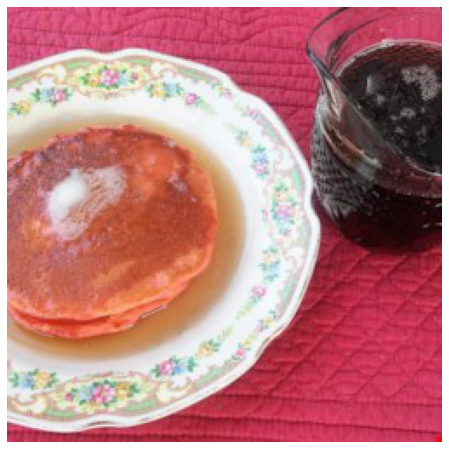

Кленово-ванильный сироп:

Real:
	сахар
	вода

Prediction:
	помидор
	черный перец
	сливочное масло
	оливки
	лук
	уксус
	соль
	курица


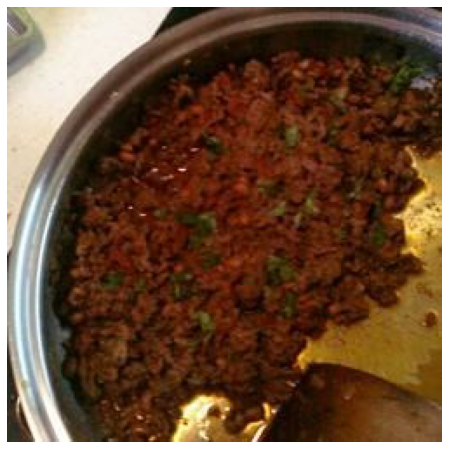

Фарш из говядины с черными глазами:

Real:
	вода
	помидор
	лимон
	говядина
	овощи
	молотый тмин
	гороха
	лук
	кинза
	соль
	чеснок

Prediction:
	вода
	перец
	говядина
	молотый тмин
	красный перец
	лук
	соль
	чеснок
	орегано


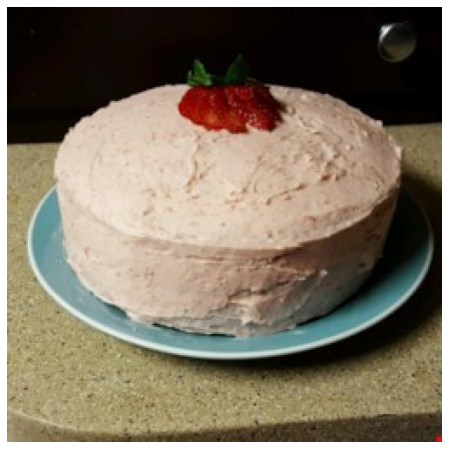

Клубничный пирог II:

Real:
	мука
	овощи
	сливочное масло
	желе
	смесь для кекса
	сахар
	яйцо

Prediction:
	вода
	овощи
	пекан
	сливочное масло
	смесь для кекса
	ваниль
	сахар
	взбитые сливки
	яйцо


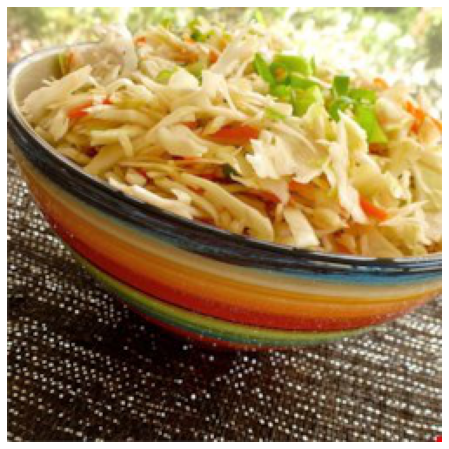

5 минут Slaw:

Real:
	сахар
	лук
	соль

Prediction:
	перец
	молотый тмин
	морковь
	красный перец
	лук
	кинза
	оливки
	лайм
	колбаса
	соль
	болгарский перец
	капуста


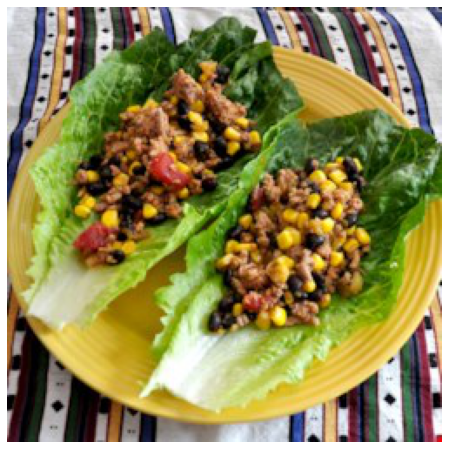

Обертывания с салатом Тако:

Real:
	помидор
	зубчик чеснока
	кукуруза

Prediction:
	тако
	помидор
	говядина
	салат
	чеддер
	лук
	тортилья
	фасоль


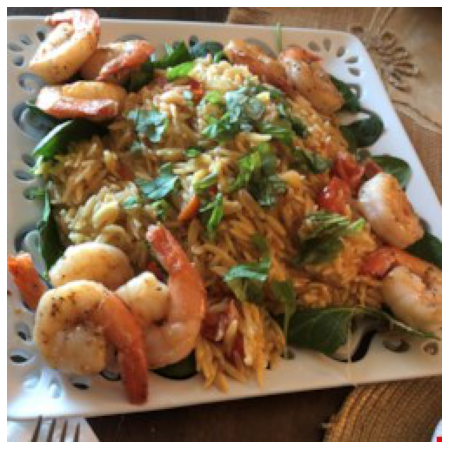

Орзо с пармезаном и базиликом:

Real:
	сливочное масло
	пармезан
	уксус
	соль

Prediction:
	креветка
	овощи
	рыба
	лук
	лайм
	колбаса
	рис
	сахар
	уксус
	кинза
	соль
	кукуруза
	курица


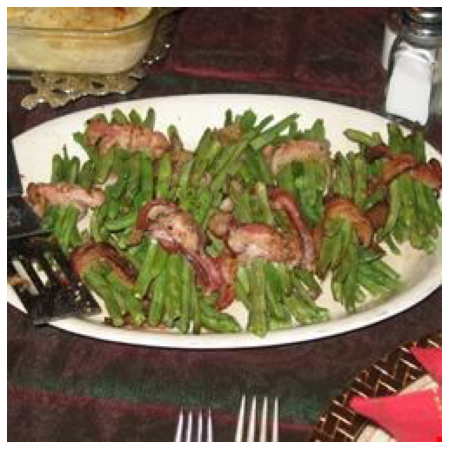

Зеленая фасоль II:

Real:
	

Prediction:
	черный перец
	говядина
	соус
	чесночный порошок
	красный перец
	сахар
	луковый порошок
	томаты черри
	ананас
	соевый соус


In [ ]:
encoder.load_state_dict(torch.load(f'/content/drive/My Drive/Dish-id/weights/enc_110_epoch.pth'))
encoder.finetune = False
decoder.load_state_dict(torch.load(f'/content/drive/My Drive/Dish-id/weights/dec_110_epoch.pth'))

encoder.eval()
decoder.eval()

for i in range(10):
  predict_val_image()